<a href="https://githubtocolab.com/Astolfo2332/shoe_classify/blob/main/00_data_setup.ipynb" target="_parent\">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" > </a>



<div style="display: flex; align-items: center;">
    <div>
        <h2>Actividad final deep learning</h2>
        <h2>Miguel López</h2>
        <h2>ID 1001014378</h2>
    </div>
    <img src="https://yt3.ggpht.com/-10IUL9wra6k/AAAAAAAAAAI/AAAAAAAAAAA/UOBLu1uYOOE/s900-c-k-no/photo.jpg" alt="Image description" width="200" style="margin-left: 20px;"/>
</div>


## 0.0 Descarga el dataset de Kaggle

In [2]:
import kagglehub

path = kagglehub.dataset_download("hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images")

/home/astolfo/anaconda3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import os

dataset_path = os.path.join(path, os.listdir(path)[0])

## 0.1 Carga del dataset

La principal idea es realizar un analisis previo para entender el dataset y sus características.

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from torch.utils.data import DataLoader, Subset
import os
import torchinfo
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [6]:
dataset = datasets.ImageFolder(dataset_path)

In [20]:
classes = dataset.classes
print(classes)

['Boot', 'Sandal', 'Shoe']


## información del dataset sin transformar

Clase: Boot
Dimensiones de la imagen: (136, 102)


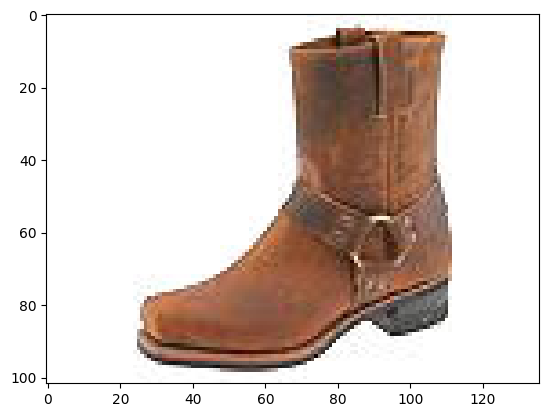

In [21]:
image, label = dataset[0]
print(f"Clase: {classes[label]}")
print(f"Dimensiones de la imagen: {image.size}")
plt.imshow(image)
plt.show()

In [7]:
labels = []
img_sizes = []
for i in range(len(dataset)):
    img, label = dataset[i]
    labels.append(classes[label])
    img_sizes.append(img.size)


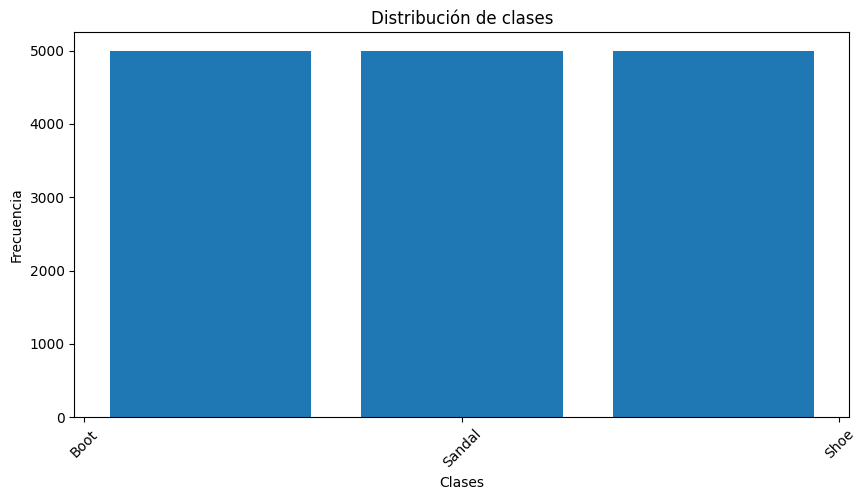

In [8]:
plt.figure(figsize=(10, 5))
plt.hist(labels, bins=len(classes), rwidth=0.8)
plt.xticks(rotation=45)
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.title("Distribución de clases")
plt.show()


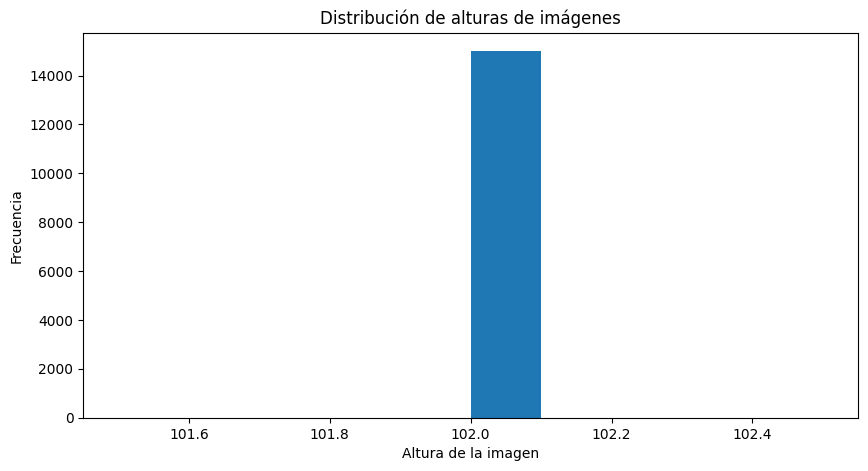

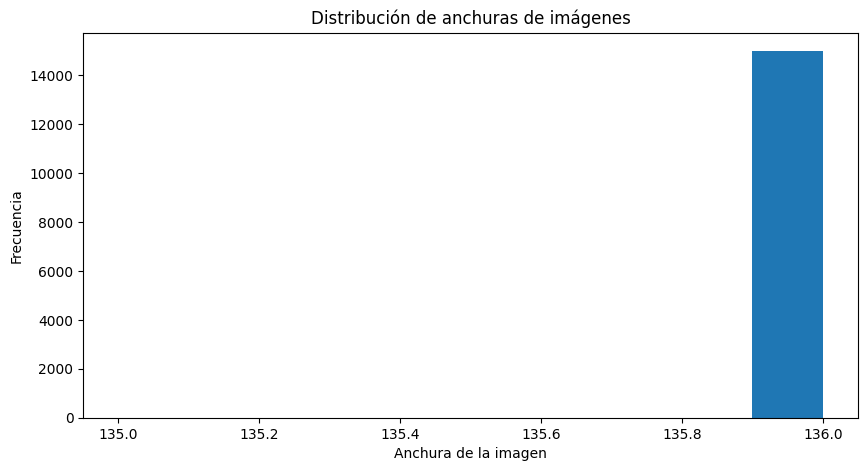

In [11]:
img_heights = [img[1] for img in img_sizes]
img_widths = [img[0] for img in img_sizes]

plt.figure(figsize=(10, 5))
plt.hist(img_heights)
plt.xlabel("Altura de la imagen")
plt.ylabel("Frecuencia")
plt.title("Distribución de alturas de imágenes")
plt.show()
plt.figure(figsize=(10, 5))
plt.hist(img_widths)
plt.xlabel("Anchura de la imagen")
plt.ylabel("Frecuencia")
plt.title("Distribución de anchuras de imágenes")
plt.show()


Al ser iguales, en todo el dataset igualmente se deben ajustar a las dimensiones estándar de 224x224.

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(dataset_path, transform=transform)

Clase: Boot
Dimensiones de la imagen: <built-in method size of Tensor object at 0x7fe765d1a7f0>


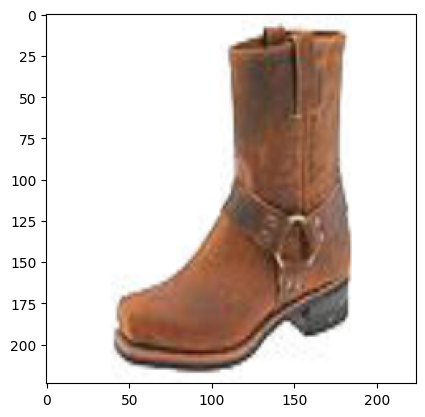

In [26]:
tensor_image, label = dataset[0]
print(f"Clase: {classes[label]}")
print(f"Dimensiones de la imagen: {image.size}")
image = tensor_image.permute(1, 2, 0)  # Cambia el orden de los ejes para mostrar la imagen
plt.imshow(image)
plt.show()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np

targets = np.array(dataset.targets)

splits = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=23)

for train_idx, val_idx in splits.split(np.zeros(len(targets)), targets):
    train_indices = Subset(dataset, train_idx)
    val_indices = Subset(dataset, val_idx)

train_dataset = DataLoader(train_indices, batch_size=32, shuffle=True)
val_dataset = DataLoader(val_indices, batch_size=32, shuffle=True)


In [14]:
train_dataset.dataset.dataset.classes

['Boot', 'Sandal', 'Shoe']

## 1.0 Carga de datos con transformaciones

In [ ]:
def download_and_get_dataset():
    path = kagglehub.dataset_download("hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images")
    dataset_path = os.path.join(path, os.listdir(path)[0])
    return dataset_path

Inicialmente se implementó una carga de datos sin augmentación, para verificar que la carga de datos funciona correctamente. En este caso se augmentan los datos para probar la capacidad de generalización del modelo.

In [9]:
def load_data(output_path: str, batch_size: int, test: int = 0.3, transform=None, augmentation=True, all_data=False):

    print("[INFO] Cargando datos")
    #Usamos una augmentación con probabilidades altas ya que los entrenamientos iniciales mostraron buenos resultados
    augmentation_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(0.8),
        transforms.RandomRotation(30),
        transforms.RandomVerticalFlip(0.6),
    ])

    dataset_path = download_and_get_dataset()
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        #Totensor automáticamente normaliza a [0,1]
        transforms.ToTensor(),
        # Realizamos la augmentación solo si se indica
        augmentation_transform if augmentation else transforms.Lambda(lambda x: x),
        # Normalizamos con los datos sugeridos por ResNet https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet152.html
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    dataset = datasets.ImageFolder(dataset_path, transform=transform)

    targets = np.array(dataset.targets)
    #Separación de test y train en partes iguales para cada clase
    splits = StratifiedShuffleSplit(n_splits=1, test_size=test, random_state=23)

    for train_idx, val_idx in splits.split(np.zeros(len(targets)), targets):
        train_indices = Subset(dataset, train_idx)
        val_indices = Subset(dataset, val_idx)

    train_loader = DataLoader(train_indices, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(val_indices, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader

## 1.1 Generación a selección de modelos

Lo siguiente es generar de manera sencilla los modelos para su posterior comparación y que sea de fácil uso y acceso posteriormente

In [ ]:
import torch
from torch import nn
import torchvision
from src.utils.engine import set_seed

def get_model(model_name: str) -> nn.Module:
    """Función para obtener el modelo a utilizar en la red neuronal. Se pueden agregar más modelos a medida que se necesiten"""

    if model_name == "tinyvgg":
        model = TinyVGG(input_shape=1, hidden_units=64, output_shape=2)
        return model

    if "custom" in model_name:
        model_name = model_name.split("_")[1]
        if model_name == "effntb0":
            model = create_effntb0()
            return model
        if model_name == "effntb2":
            model = create_effntb2()
            return model
        if model_name == "convnextTiny":
            model = create_convnext_tiny()
            return model
        if model_name == "convnextSmall":
            model = create_convnext_small()
            return model
        if model_name == "resnet50":
            model = create_resnet50()
            return model
        if model_name == "resnet101":
            model = create_resnet101()
            return model
        if model_name == "resnet152":
            model = create_resnet152()
            return model

    model = create_resnet152()
    return model

class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv3d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv3d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv3d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv3d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.LayerNorm((7683200,), elementwise_affine=False, eps=1e-5),
            nn.Linear(in_features= 7683200,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x


def create_effntb0() -> nn.Module:
    #Se obtienen los pesos del model y se cargan
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights)
    model = freeze_parameters(model)
    print("[INFO] create new effntb0 model.")
    return model

def freeze_parameters(model: nn.Module) -> nn.Module:
    """Función para congelar los parámetros de un modelo y así solo entrenar sus capas de clasificación"""
    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True), #Dropout para evitar overfitting
        torch.nn.Linear(in_features=1280, out_features=3, bias=True) # La salida van a ser las 3 clases
    )
    return model

def create_effntb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        #En este caso se debe cambiar manualmente el tamaño de la capa de entrada por las propiedades del modelo
        torch.nn.Dropout(p=0.3, inplace=True),
        torch.nn.Linear(in_features=1408, out_features=3, bias=True)
    )
    print("[INFO] create new effntb2 model.")
    return model

def create_convnext_tiny():
    weights = torchvision.models.ConvNeXt_Tiny_Weights.DEFAULT
    model = torchvision.models.convnext_tiny(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True),
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(in_features=768, out_features=2, bias=True)
    )
    print("[INFO] create new convnext_tiny model.")
    return model

def create_convnext_small():
    weights = torchvision.models.ConvNeXt_Small_Weights.DEFAULT
    model = torchvision.models.convnext_small(weights=weights)
    for param in model.features.parameters():
        param.requires_grad = False

    set_seed()

    model.classifier = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.LayerNorm((768,), eps=1e-06, elementwise_affine=True),
        torch.nn.Flatten(start_dim=1, end_dim=-1),
        torch.nn.Linear(in_features=768, out_features=2, bias=True)
    )
    print("[INFO] create new convnext_small model.")
    return model

def create_resnet50():
    weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet50(weights=weights)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=model.fc.in_features, out_features=3, bias=True)
    )
    print("[INFO] create new resnet50 model.")
    return model

def create_resnet101():
    weights = torchvision.models.ResNet101_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet101(weights=weights)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=model.fc.in_features, out_features=3, bias=True)
    )
    print("[INFO] create new resnet101 model.")
    return model

def create_resnet152():
    weights = torchvision.models.ResNet152_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet152(weights=weights)
    for param in model.parameters():
        param.requires_grad = False

    model.fc = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True),
        torch.nn.Linear(in_features=model.fc.in_features, out_features=3, bias=True)
    )
    print("[INFO] create new resnet152 model.")
    return model


## 1.2.1 Entrenamiento del modelo test

Primero necesitamos un pipeline de entrenamiento, sabemos que la idea general para entrenar una red neuronal es:
- Realizar un forward pass
- Calcular la función de pérdida
- Realizar un backward pass
- Actualizar los pesos
- Repetir el proceso
- Evaluar el modelo
- Guardar el modelo

Adicionalmente a esto se pueden guardar los datos en un tensorboard para su posterior análisis.

In [ ]:
def set_seed(seed: int=23):
    """
    Establece una semilla para la reproducibilidad de los resultados.

    Args:
        seed (int, optional): Semilla a establecer. Por defecto es 23.
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def train_func(model: nn.Module, data: torch.utils.data.DataLoader, loss_fn:nn.Module,
               optimizer: torch.optim.Optimizer, device: torch.device):
    #Inicializamos las variables para guardar los resultados
    train_loss, train_acc = 0, 0
    all_preds = []
    all_labels = []
    #Se usa el modelo modo entrenamiento
    model.train()
    #Iteramos sobre el dataset
    for bathc, (X, y) in enumerate(data):
        #Se separan los datos y etiquetas además se cargan en la gpu
        X, y = X.to(device), y.to(device)
        #Realizamos el forward pass
        y_logit = model(X)
        #Calculamos la función de pérdida
        loss = loss_fn(y_logit, y)
        #Se guarda la pérdida
        train_loss += loss.item()
        #Realizamos el backward pass
        optimizer.zero_grad()
        loss.backward()
        #Actualizamos los pesos
        optimizer.step()
        #Calculamos el accuracy y guardamos los resultados
        y_pred = torch.softmax(y_logit, 1).argmax(1) #Recordar que se debe pasar a softmax para obtener la probabilidad
        train_acc += (y_pred == y).sum().item() / len (y_pred)
        all_preds.extend(y_pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
    #Se calcula la pérdida y el accuracy promedio
    train_loss = train_loss / len(data)
    train_acc = train_acc / len(data)

    return train_loss, train_acc, all_preds, all_labels


## 1.2.2 Evaluación del modelo

In [ ]:
def test_func(model: nn.Module, data: DataLoader, loss_fn: nn.Module, device: torch.device):
    #Se pasa el modelo a modo evaluación y así evitar cálculos innecesarios
    model.eval()
    #Inicializamos las variables para guardar los resultados
    test_loss, test_acc = 0, 0
    all_preds = []
    all_labels = []
    #Se usa el inference mode para evitar llevar los gradientes
    with torch.inference_mode():
        #Iteramos sobre el dataset
        for batch, (X, y) in enumerate(data):
            X, y = X.to(device), y.to(device)
            y_logits = model(X)
            #En este caso al ser test no se actualizan los pesos
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()
            y_pred = y_logits.argmax(1)
            #Se guardan las metricas de manera similar a train
            test_acc += (y_pred == y).sum().item() / len (y_pred)
            all_preds.extend(y_pred.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    test_loss = test_loss / len(data)
    test_acc = test_acc / len(data)
    #Devolvemos toda la información para un futuro analisis
    return test_loss, test_acc, all_preds, all_labels


### 1.2.3 Seguimiento de los datos

Como se mencionó anteriormente se usa tensorboard para guardar los datos y así poder analizarlos posteriormente.

In [ ]:
from typing import Dict, List, Tuple
import torch
import os
from torch.utils.data import DataLoader
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.auto import tqdm
from datetime import datetime
from utils.engine import train_func, test_func
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, auc, recall_score
import seaborn as sns

def create_write(name: str, model: str, experiment_name: str,extra: str=None) -> SummaryWriter():

    #Se guarda la fecha y hora para crear un directorio único
    timestamp = datetime.now().strftime("%Y-%m-%d")
    #El parametro extra puede ser usado para guardar las epocas o el tipo de modelo
    if extra:
        log_dir = os.path.join("runs", timestamp, experiment_name, name, model, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, name, model)
    print(f"[INFO] create summary writer, saving to: {log_dir}")
    return SummaryWriter(log_dir=log_dir)


### 1.2.4 Selección de optimizador

Se realiza una función para seleccionar un optimizador con la idea que los hiperparametros sean ajustables mediante un json

In [ ]:
def select_optimizer(model: nn.Module, optimizer: str):
    if optimizer == "Adam":
        return torch.optim.Adam(model.parameters(), lr=0.001)
    if optimizer == "SGD":
        return torch.optim.SGD(model.parameters(), lr=0.001)
    if optimizer == "Adamw":
        return torch.optim.AdamW(model.parameters(), lr=0.001)


## 1.2.5 Metricas adicionales para evaluar el modelo

Se adicionan metricas adicionales para tener una mejor comparación del modelo, al ser clasificación se usan métricas como el recall, precision y f1-score.
Además de gráficas como la matriz de confusión para visualizar las clases donde el modelo tiene más dificultad de generalización.

In [ ]:
def plot_confusion_matrix(cm, class_names,title):
    """Plotea la matriz de confusión"""
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.close(fig)
    return fig

### 2 Entrenamiento del modelo

Con todas las funciones anteriores podemos realizar el entrenamiento del modelo. Guardar los resultados e ir ajustando los hiperparametros.

In [ ]:
def train(model: nn.Module, test_data: DataLoader, train_data: DataLoader, loss_fn:nn.Module,
          optimizer: torch.optim.Optimizer, device: torch.device, epochs: int
          , writer: SummaryWriter, title: str) -> Dict[str, List]:

    #Se inicializan las variables para guardar los resultados
    best_test_acc = 0
    best_train_loss = 1000
    best_model = None

    #Creamos un diccionario para guardar los resultados y escribirlos más fácilmente
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    #Iteramos entre las epocas
    for epoch in tqdm(range(epochs)):
        #Realizamos el entrenamiento como se muestra en 1.2.1
        train_loss, train_acc,train_preds, train_labes = train_func(
            model,train_data,loss_fn,optimizer, device)
        #Realizamos la evaluación como se muestra en 1.2.2
        test_loss, test_acc, test_preds, test_labels = test_func(
            model, test_data, loss_fn, device)

        #Calculamos las metricas adicionales de cada epoca
        train_f1 = f1_score(train_labes, train_preds, average="weighted")
        test_f1 = f1_score(test_labels, test_preds, average="weighted")
        train_recall = recall_score(train_labes, train_preds, average="weighted")
        test_recall = recall_score(test_labels, test_preds, average="weighted")


        #Imprimimos los resultados para tener un seguimiento en tiempo real
        print(
            "\n"
            f"Epoch {epoch+1} |"
            f"train_loss :{train_loss: .4f} |"
            f"train_acc :{train_acc: .4f} |"
            f"test_loss :{test_loss: .4f} |"
            f"test_acc :{test_acc: .4f} |"
            f"train_f1_w :{train_f1: .4f} |"
            f"test_f1_w :{test_f1: .4f} |"
            f"train_recall :{train_recall: .4f} |"
            f"test_recall :{test_recall: .4f} "
        )
        #Guardamos los resultados en el diccionario
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)



        ##Se agregan los resultados a tensorboard para su posterior análisis, y como parametro se guardan las epocas
        if writer:
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss, "tests_loss": test_loss},
                               global_step=epoch
                               )

            writer.add_scalars(main_tag="Accuracy",
                               tag_scalar_dict={"train_acc": train_acc, "tests_acc": test_acc},
                               global_step=epoch
                               )

            writer.add_scalars(main_tag="F1_weighted",
                               tag_scalar_dict={"train_f1_w": train_f1, "tests_f1_w": test_f1},
                               global_step=epoch
                               )

            writer.add_scalars(main_tag="Recall_weighted",
                               tag_scalar_dict={"train_recall": train_recall, "tests_recall": test_recall},
                               global_step=epoch
                               )

            # Se agrega la matriz de confusión al final del test
            if epoch == epochs - 1:
                cm = confusion_matrix(test_preds, test_labels)
                cm_fig = plot_confusion_matrix(cm, train_data.dataset.dataset.classes, title)
                writer.add_figure("Confusion Matrix", cm_fig, global_step=epoch)


        # Para guardar el mejor modelo
        if test_acc > best_test_acc and train_loss < best_train_loss:
            best_test_acc = train_acc
            best_train_loss = train_loss
            best_model = model.state_dict()

    return results, best_model, best_test_acc, cm_fig, test_loss


### 3 Generación de experimentos

Ahora que tenemos una forma fácil de entrenar distintos modelos, se requiere una función con la cual realizar variaciones y experimentos.

In [ ]:
def run_experiments(test_dataloader: DataLoader, train_dataloader: DataLoader, parameters: dict, w_loss= False):

    #Se limpia la memoria de la gpu para evitar problemas de memoria
    torch.cuda.empty_cache()

    #Se establece el dispositivo a usar, en este caso la gpu aunque depende del hardware
    device = "cuda" if torch.cuda.is_available() else "cpu"
    set_seed()


    #Se obtienen los parametros del json
    experiment_name = parameters["name"]
    num_epochs = parameters["epochs"]
    optimizers = parameters["optimizers"]
    experiment_number = 0

    # Como es una clasificación multiclase se usa la función de pérdida de entropía cruzada, además que las clases estan balanceadas
    if w_loss:
        #Se implementa una variación de pesos de clase solo como prueba
        loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([2.0, 1.0, 1.0])).to(device) #El doble de peso para los 0
    else:
        loss_fn = nn.CrossEntropyLoss().to(device)
    conf_mat = []

    #Se itera primero entre los modelos
    for model_name in parameters["models"]:
        best_test_acc = 0
        best_checkpoint = None
        best_test_loss = 1000
        #Se itera entre la cantidad de epocas
        for epochs in num_epochs:
            #Se itera entre los optimizadores
            for optimizer_name in optimizers:
                experiment_number += 1
                print(f"[INFO] Experiment number: {experiment_number}")
                print(f"[INFO] model: {model_name}")
                print(f"[INFO] Optimizer: {optimizer_name}")
                print(f"[INFO] Epochs: {epochs}")
                #Usando al funcion de modelo se obtiene por su nombre y se carga en la gpu
                model = get_model(model_name).to(device)
                #Se crea el writer para guardar los resultados
                writer = create_write(name=optimizer_name,
                                      model=model_name, experiment_name=experiment_name, extra=str(epochs))
                #Se selecciona el optimizador
                optimizer = select_optimizer(model, optimizer_name)
                #Se realiza el entrenamiento y se obtienen los resultados para guardar el mejor modelo
                results, best_model, test_acc, cm_fig, test_loss = train(model, test_dataloader, train_dataloader, loss_fn, optimizer, device,
                                                                         epochs, writer, experiment_name + "/" + model_name + "/" + optimizer_name + "/" + str(epochs))
                print("-" * 50 + "\n")

                # Cada epoca se guardan los resultados y el mejor modelo
                if test_loss < best_test_loss:
                    best_test_acc = test_acc
                    best_checkpoint = best_model
                    best_optimizer = optimizer_name
                    best_epochs = epochs
                    best_model_name = model_name
                    best_test_loss = test_loss

            conf_mat.append(cm_fig)
        # Se guarda un modelo como checkpoint para así evitar el overfitting y facilitar su carga
        if best_checkpoint:
            print(f"[INFO] Best model: {best_model_name} with optimizer: {best_optimizer} and epochs: {best_epochs}")
            path = f"./models/{experiment_name}/{best_model_name}/{best_optimizer}/{best_epochs}"
            os.makedirs(path, exist_ok=True)
            torch.save(best_checkpoint, path + f"/best_model_{best_model_name}.pth")

    torch.cuda.empty_cache()
    return conf_mat


## 4 pipeline

Se une todas las funciones anteriores, con la idea de que los experimentos sean manejados a traves de un json

In [ ]:
import json
def pipeline(output_folder, inference_path):
    with open("parameters.json", "r",encoding="utf-8") as file:
        parameters = json.load(file)

    AUGMENTATION = True
    ALL_DATA = False
    WEIGHTED_LOSS = False

    if "no_augmentation" in parameters:
        AUGMENTATION = False
        WEIGHTED_LOSS = True

    if "no_all_data" in parameters:
        ALL_DATA = False
        WEIGHTED_LOSS = True

    print("[INFO] Creando dataloaders")
    train_loader, test_loader = load_data(output_folder, parameters["batches"],
                                          augmentation=AUGMENTATION, all_data=ALL_DATA)
    print("[INFO] Dataloaders creados")


    print("[INFO] Iniciando entrenamiento")
    run_experiments(test_loader, train_loader, parameters, w_loss=False)
    print("[INFO] Entrenamiento finalizado")

    return

In [ ]:
OUTPUT_PATH = "output/"
INFERENCE_PATH = "inference/"

pipeline(OUTPUT_PATH, INFERENCE_PATH)


## 5 Conclusiones